<a href="https://colab.research.google.com/github/JeiGeek/ia1-LosPandas-prediccion_rendimiento_estudiantil/blob/main/03_Unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# @title **Librerias**
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

# Partición de dataset
from sklearn.model_selection import train_test_split

# Particion de entrenamiento KFol y tunning
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, KFold, RandomizedSearchCV

# Librerias de modelos
from sklearn.svm import SVR

# Deep learning
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Librerias para reporte de metricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score, matthews_corrcoef, make_scorer, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# **Carga del dataset y configuraciones**

In [18]:
# Carga desde github
url = "https://raw.githubusercontent.com/JeiGeek/ia1-LosPandas-prediccion_rendimiento_estudiantil/main/Dataset/StudentPerformanceFactors.csv"
df = pd.read_csv(url)

In [19]:
# Limpieza de nulos y valores fuera del margen
df = df.dropna()
df = df[df['Exam_Score'] <= 100]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6377 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6377 non-null   int64 
 1   Attendance                  6377 non-null   int64 
 2   Parental_Involvement        6377 non-null   object
 3   Access_to_Resources         6377 non-null   object
 4   Extracurricular_Activities  6377 non-null   object
 5   Sleep_Hours                 6377 non-null   int64 
 6   Previous_Scores             6377 non-null   int64 
 7   Motivation_Level            6377 non-null   object
 8   Internet_Access             6377 non-null   object
 9   Tutoring_Sessions           6377 non-null   int64 
 10  Family_Income               6377 non-null   object
 11  Teacher_Quality             6377 non-null   object
 12  School_Type                 6377 non-null   object
 13  Peer_Influence              6377 non-null   object
 1

In [20]:
# Hay 13 variables de tipo categoricas, se convierten en tipo numericas (se le da un valor ya sea 0 y 1, o 1,2,3)

df_encoded = df.copy()

# Categorizacion binaria para categorias que son solo 2 dos tipos

# get_dummies - Convierte tablas categoricas en binarios
# drop_first - quita la columna redudante que se genera
df_encoded = pd.get_dummies(df_encoded, columns=["Extracurricular_Activities", "Internet_Access", "School_Type", "Learning_Disabilities", "Gender"], drop_first=True)

# Categorizacion por categorias que son de 3 tipos

# para categorias bajo - medio - alto
mapping = {"Low":1, "Medium":2, "High":3}
columnas = ["Parental_Involvement", "Access_to_Resources", "Motivation_Level", "Family_Income", "Teacher_Quality"]

for columna in columnas:
    df_encoded[columna] = df_encoded[columna].map(mapping)

# para categoria negativo - positivo - neutral
mapping = {"Negative":-1, "Positive":1, "Neutral":0}
df_encoded["Peer_Influence"] = df_encoded["Peer_Influence"].map(mapping)

# para categoria High School - College - Postgraduate
mapping = {"High School":1, "College":2, "Postgraduate":3}
df_encoded["Parental_Education_Level"] = df_encoded["Parental_Education_Level"].map(mapping)

# para categoria Near - Moderate - Far
mapping = {"Near":1, "Moderate":2, "Far":3}
df_encoded["Distance_from_Home"] = df_encoded["Distance_from_Home"].map(mapping)


# Convertir las columnas booleanas resultantes en 0 y 1
bool_cols = df_encoded.select_dtypes(include=["bool"]).columns # Se seleccionan las columnas solamente las columnas booleanas
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int) # Se convierten en 0 y 1

# PCA

# **Clasificacion por puntaje mayor igual a *70*** - Supervisado

---

In [5]:
# @title Preparacion de del dataset

# copia del DataFrame
df_60 = df_encoded.copy()

# Agregar la columna booleana de aprobados si tiene valor mayor igual a 70
df_60['Aprobados'] = df_60['Exam_Score'] >= 70

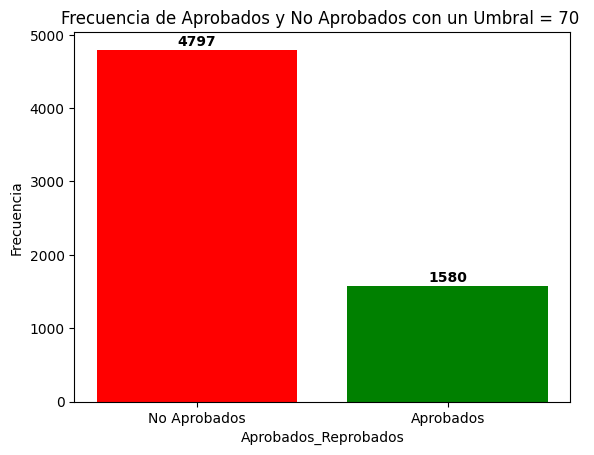

In [6]:
# @title Visualización de datos por categoría

# Frecuencias por categoría
categorias = df_60['Aprobados'].value_counts()

# Colores para True y False
colores = ['green' if valor else 'red' for valor in categorias.index]

etiquetas = ['Aprobados' if valor else 'No Aprobados' for valor in categorias.index]
plt.bar(etiquetas, categorias.values, color=colores)

# Añadir los valores encima de cada barra
for i, v in enumerate(categorias.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')  # el +50 es para que no se superponga

# Títulos y etiquetas
plt.title('Frecuencia de Aprobados y No Aprobados con un Umbral = 70 ')
plt.xlabel('Aprobados_Reprobados')
plt.ylabel('Frecuencia')

plt.show()

In [7]:
#@title Primera partición de dataset para evaluar y evitar sobre entrenamiento
X = df_60.drop(['Exam_Score','Aprobados'], axis=1)
y = df_60['Aprobados']

# Partición inicial Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80 train - 20 test
    stratify=y,          # mantiene proporciones del desbalance
    random_state=42
)

## **Deep learning - Modelo Superisado**

In [15]:
# @title Proceso de entrenamiento

# Semilla fija
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Preparación del modelo
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Salida binaria
])

model.summary()

# Correr modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del modelo
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=60,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=10, restore_best_weights=True)]
)

# Evaluación final
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calcular métricas
balanced_acc = balanced_accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Especificidad = TN / (TN + FP)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,385 (189.00 KB)

 Trainable params: 48,385 (189.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7192 - loss: 0.5368 - val_accuracy: 0.9295 - val_loss: 0.2239
Epoch 2/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9514 - loss: 0.1844 - val_accuracy: 0.9500 - val_loss: 0.1339
Epoch 3/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9742 - loss: 0.1167 - val_accuracy: 0.9481 - val_loss: 0.1206
Epoch 4/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9801 - loss: 0.0931 - val_accuracy: 0.9520 - val_loss: 0.1149
Epoch 5/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9857 - loss: 0.0782 - val_accuracy: 0.9559 - val_loss: 0.1112
Epoch 6/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9879 - loss: 0.0667 - val_accuracy: 0.9598 - val_loss: 0.1098
Epoch 7/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9899 - loss: 0.0571 - val_accuracy: 0.9628 - val_loss: 0.1112
Epoch 8/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9919 - loss: 0.0490 - val_accuracy: 0.9628 - val_loss:

In [16]:
# Reporte de metricas
print("Resultados del modelo de Clasificación (Deep Learning):\n")
print(f"Balanced Accuracy : {balanced_acc:.4f}")
print(f"Recall (Sensibilidad): {recall:.4f}")
print(f"Especificidad: {specificity:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

Resultados del modelo de Clasificación (Deep Learning):

Balanced Accuracy : 0.9416
Recall (Sensibilidad): 0.8987
Especificidad: 0.9844
Precisión: 0.9498
F1-Score: 0.9236


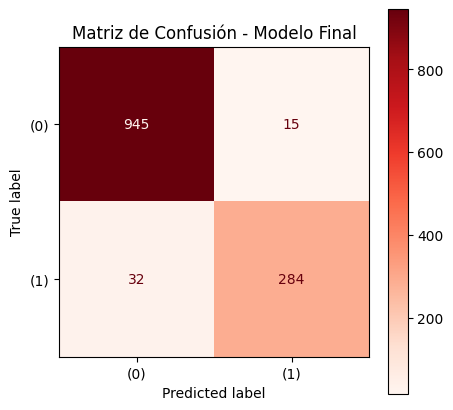

In [17]:
# @title Matriz de confusión
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["(0)", "(1)"]
)

# Graficar
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    cmap="Reds",
    values_format="d",
    ax=ax
)
plt.title("Matriz de Confusión - Modelo Final")
plt.show()

## **Deep learning - Reducción dimensional**

# **Regresión** - Supervisado

---

In [21]:
#@title Primera partición de dataset para evaluar y evitar sobre entrenamiento

# Copia del DataFrame
df_r = df_encoded.copy()

# Variables predictoras (todas menos Exam_Score)
X = df_r.drop(['Exam_Score'], axis=1)

# Variable objetivo
y = df_r['Exam_Score']

# Partición inicial Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% train - 20% test
    random_state=42
)

In [22]:
# @title Función de regresion
def flujo_regresion(modelo, param_grid, score, X_train, X_test, y_train, y_test):

  # Validación cruzada
  cv = KFold(n_splits=5, shuffle=True, random_state=42)

  # Tuning con grid_search
  grid = GridSearchCV(
      estimator=modelo,
      param_grid=param_grid,
      cv=cv,
      scoring= score,
      n_jobs=-1,
      return_train_score=True
  )

  # Entrenamiento del GridSearch
  grid.fit(X_train, y_train)

  # Obtención del mejor modelo
  mejor_modelo = grid.best_estimator_

  # Metricas de cada fold del mejor modelo
  scores_folds = cross_val_score(
      mejor_modelo, X_train, y_train,
      cv=cv,
      scoring= score
  )

  # Entrenamiento del modelo fina con todo el x_train y evaluar con el test
  mejor_modelo.fit(X_train, y_train)
  y_pred = mejor_modelo.predict(X_test)

  absolte_error = mean_absolute_error(y_test, y_pred)
  mean_squared = mean_squared_error(y_test, y_pred)

  # Importancia de columnas
  try: # manejo de error para el SVC
    importantes = pd.DataFrame({
        'Columna': X_train.columns,
        'Importancia': mejor_modelo.feature_importances_
    })
  except AttributeError:
    result = permutation_importance(
        mejor_modelo, X_test, y_test,
        scoring=score,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    importantes = pd.DataFrame({
        'Columna': X_train.columns,
        'Importancia': result.importances_mean
    })

  return grid, scores_folds, absolte_error, mean_squared, importantes, y_pred

## **Support Vector Machine - Modelo supervisado**

In [25]:
# Modelo base
svr = SVR()

# Definición del grid de hiperparámetros
param_grid = {
    'kernel': ['rbf','sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Metrica de mejora del modelo
score = make_scorer(mean_absolute_error, greater_is_better=False)
# Llamado de la función
grid, scores_folds, absolte_error, mean_squared, importantes2, y_pred = flujo_regresion(svr, param_grid, score, X_train, X_test, y_train, y_test)

In [26]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor evaluación promedio:", -grid.best_score_)

Mejores hiperparámetros: {'gamma': 0.001, 'kernel': 'rbf'}
Mejor evaluación promedio: 0.6500471053963317


In [27]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("MAE:", round(absolte_error, 4))
print("MSE:", round(mean_squared, 4))

Evaluación final:
MAE: 0.5832
MSE: 4.32


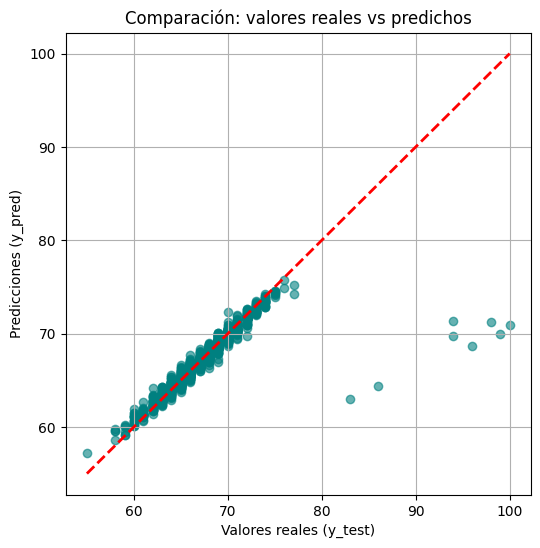

In [28]:
# @title Gráfico de valores reales vs predicciones

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)  # línea ideal (predicción perfecta)

plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Comparación: valores reales vs predichos")
plt.grid(True)
plt.show()

## **Support Vector Machine - Reducción dimensional**

# **Clasificacion por puntaje mayor igual a *70*** - No supervisado

---

# **Regresión** - No supervisado

---